In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import keras.backend as K
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import SparseCategoricalCrossentropy

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0
gpu-ibanks-3.hep.caltech.edu  Thu Aug 26 08:25:47 2021  470.57.02
[0] NVIDIA GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[1] NVIDIA GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[2] NVIDIA GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[3] NVIDIA GeForce GTX 1080 | 22'C,   0 % |     1 /  8119 MB |
[4] NVIDIA GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[5] NVIDIA GeForce GTX 1080 | 25'C,   0 % |   727 /  8119 MB | 3012(723M)
[6] NVIDIA GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[7] NVIDIA GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |


### Load MC samples

In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    tree_vars = [b'leading_photon_pt', b'subleading_photon_pt', b'diphoton_pt', b'diphoton_mass',
           b'leading_bjet_pt', b'subleading_bjet_pt', b'dibjet_pt', b'dibjet_mass',
           b'leading_bjet_pt_corr', b'subleading_bjet_pt_corr', b'dibjet_pt_corr', b'dibjet_mass_corr',
           b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr',
           b'subleading_pho_pt_over_dimass', b'subleading_bjet_pt_over_dimass', b'subleading_bjet_pt_over_dimass_corr',
           b'leading_photon_phi', b'leading_photon_eta', b'subleading_photon_phi', b'subleading_photon_eta',
           b'diphoton_eta', b'photon_delR', b'diphoton_pt_over_diphoton_mass',
           b'leading_bjet_phi', b'leading_bjet_eta', b'subleading_bjet_phi', b'subleading_bjet_eta',
           b'dibjet_eta', b'bjet_delR', b'dibjet_pt_over_dibjet_mass', b'dibjet_pt_over_dibjet_mass_corr',
           b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
           b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
           b'leading_vbfjet_pt', b'subleading_vbfjet_pt', b'divbfjet_pt', b'divbfjet_mass',
           b'leading_vbfjet_phi', b'leading_vbfjet_eta', b'subleading_vbfjet_phi', b'subleading_vbfjet_eta',
           b'leading_vbfjet_pt_over_dimass', b'subleading_vbfjet_pt_over_dimass', b'divbfjet_pt_over_dimass',
           b'divbfjet_eta', b'vbfjet_delR', b'vbfjet_del_eta',
           b'MET_pt', b'MET_phi', b'MET_sumEt',
           b'recon', b'ggHH_recon', b'VBFHH_recon', b'genweight', b'nbjet', b'nvbfjet', b'nphoton', b'njet',
           b'run', b'lumi', b'event']
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays(tree_vars)
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs)
    return combine_df

In [3]:
# Set up dataframes - 2018 

# Signals
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2018= samp_to_df('job_3_ntuple20180819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job3ifile', 0)

# Backgrounds
VHToGG_df_2018 = samp_to_df('job_4_ntuple20180819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2018 = samp_to_df('job_5_ntuple20180819v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHToGG_df_2018 = samp_to_df('job_6_ntuple20180819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job6ifile', 0)
GluGluHToGG_df_2018 = samp_to_df('job_7_ntuple20180819v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job7ifile', 0)
TTJets_df_2018 = samp_to_df('job_8_ntuple20180819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 60)
TTGJets_df_2018 = samp_to_df('job_9_ntuple20180819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 3)
TTGG_0Jets_df_2018 = samp_to_df('job_10_ntuple20180819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 5)
GJet_SmallPt_df_2018 = samp_to_df('job_11_ntuple20180819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 3)
GJet_BigPt_df_2018 = samp_to_df('job_12_ntuple20180819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 2)
DiPhotonJetsBox_df_2018 = samp_to_df('job_13_ntuple20180819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 4)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_14_ntuple20180819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 0)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_15_ntuple20180819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 0)
QCD_Jets_df_2018 = samp_to_df('job_16_ntuple20180819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 15)

# Set up dataframes - 2017

# Signals
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
VBFHH_df_2017 = samp_to_df('job_3_ntuple20170819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 1)

# Backgrounds
VHToGG_df_2017 = samp_to_df('job_4_ntuple20170819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_5_ntuple20170819v1/ttHToGG_M125_13TeV_powheg_pythia8Job5ifile', 0)
VBFHToGG_df_2017 = samp_to_df('job_6_ntuple20170819v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job6ifile', 2)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170819v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 0)
TTJets_df_2017 = samp_to_df('job_8_ntuple20170819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 38)
TTGJets_df_2017 = samp_to_df('job_9_ntuple20170819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 10)
TTGG_0Jets_df_2017 = samp_to_df('job_10_ntuple20170819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 1)
GJet_SmallPt_df_2017 = samp_to_df('job_11_ntuple20170819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2017 = samp_to_df('job_12_ntuple20170819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 20)
DiPhotonJetsBox_df_2017 = samp_to_df('job_1_ntuple20170819v2/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob1ifile', 16)
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_14_ntuple20170819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_15_ntuple20170819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 5)
QCD_Jets_df_2017 = samp_to_df('job_16_ntuple20170819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 3)

# Set up dataframes - 2016 

# Signals
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2016 = samp_to_df('job_3_ntuple20160819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 0)

# Background
VHToGG_df_2016 = samp_to_df('job_4_ntuple20160819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2016 = samp_to_df('job_5_ntuple20160819v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job5ifile', 0)
VBFHToGG_df_2016 = samp_to_df('job_6_ntuple20160819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job6ifile', 2)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160819v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTJets_df_2016 = samp_to_df('job_8_ntuple20160819v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job8ifile', 8)
TTGJets_df_2016 = samp_to_df('job_9_ntuple20160819v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 2)
TTGG_0Jets_df_2016 = samp_to_df('job_10_ntuple20160819v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job10ifile', 0)
GJet_SmallPt_df_2016 = samp_to_df('job_11_ntuple20160819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2016 = samp_to_df('job_12_ntuple20160819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job12ifile', 12)
DiPhotonJetsBox_df_2016 = samp_to_df('job_13_ntuple20160819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 9)
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_14_ntuple20160819v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_15_ntuple20160819v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob15ifile', 4)
QCD_Jets_df_2016 = samp_to_df('job_16_ntuple20160819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job16ifile', 3)

# Combine by sample (recon == 1; photon cut == 90)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
TTJets_df= pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)

In [33]:
# downsize DiPhotonsJetsBox
DiPhotonJetsBox_df_shuff = DiPhotonJetsBox_df.sample(frac=1).reset_index(drop=True)
DiPhotonJetsBox_df_short = DiPhotonJetsBox_df_shuff.truncate(after = 197069)
dpjb_total_weight = np.sum(DiPhotonJetsBox_df.loc[:, b'genweight'].values)
dpjb_short_weight = np.sum(DiPhotonJetsBox_df_short.loc[:, b'genweight'].values)
DiPhotonJetsBox_df_short[b'genweight'] = DiPhotonJetsBox_df_short.loc[:, b'genweight'].values * dpjb_total_weight / dpjb_short_weight 

In [34]:
DiPhotonJetsBox_df_shuff.head()

,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'ggHH_recon',b'VBFHH_recon',b'genweight',b'nbjet',b'nvbfjet',b'nphoton',b'njet',b'run',b'lumi',b'event'
0,128.114471,62.758732,77.458313,176.939438,121.93750,50.31250,93.515129,147.175385,121.342102,54.144897,...,1.0,0.0,0.010877,3,1,2,5,1,248189,38965656
1,51.772621,43.534180,41.382004,139.144211,44.71875,34.40625,40.427334,80.006912,49.216827,39.110229,...,1.0,0.0,0.021754,3,1,2,9,1,279465,43875912
2,40.288132,32.223526,40.255985,100.306778,49.28125,34.40625,44.016804,130.266663,56.644562,38.337433,...,1.0,0.0,0.021754,2,0,2,5,1,246554,38708969
3,76.429977,25.934137,50.590046,103.110619,37.25000,33.18750,8.762375,102.271538,42.124512,47.577393,...,1.0,0.0,0.010877,2,0,2,5,1,95809,15041973
4,70.929611,48.398479,28.968330,126.161942,79.43750,42.21875,37.590191,117.117676,83.083557,48.361908,...,1.0,0.0,0.016187,2,0,2,9,1,57217,54927874


In [35]:
DiPhotonJetsBox_df_short.head()

,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'ggHH_recon',b'VBFHH_recon',b'genweight',b'nbjet',b'nvbfjet',b'nphoton',b'njet',b'run',b'lumi',b'event'
0,128.114471,62.758732,77.458313,176.939438,121.93750,50.31250,93.515129,147.175385,121.342102,54.144897,...,1.0,0.0,0.125700,3,1,2,5,1,248189,38965656
1,51.772621,43.534180,41.382004,139.144211,44.71875,34.40625,40.427334,80.006912,49.216827,39.110229,...,1.0,0.0,0.251399,3,1,2,9,1,279465,43875912
2,40.288132,32.223526,40.255985,100.306778,49.28125,34.40625,44.016804,130.266663,56.644562,38.337433,...,1.0,0.0,0.251399,2,0,2,5,1,246554,38708969
3,76.429977,25.934137,50.590046,103.110619,37.25000,33.18750,8.762375,102.271538,42.124512,47.577393,...,1.0,0.0,0.125700,2,0,2,5,1,95809,15041973
4,70.929611,48.398479,28.968330,126.161942,79.43750,42.21875,37.590191,117.117676,83.083557,48.361908,...,1.0,0.0,0.187062,2,0,2,9,1,57217,54927874


In [5]:
# Select ggHH signal specifically -- pho == 90

dfs_combine = [GluGluToHH_df, VBFHH_df,
               VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df, 
                TTJets_df, TTGJets_df, TTGG_0Jets_df, 
            GJet_SmallPt_df, GJet_BigPt_df,
             DiPhotonJetsBox_df_short, DiPhotonJetsBox1B_df, DiPhotonJetsBox2B_df, QCD_Jets_df]

dfs_ggHH = []

for i in range(len(dfs_combine)):
    df_ggHH = dfs_combine[i][dfs_combine[i][b'ggHH_recon'] == 1]
    dfs_ggHH.append(df_ggHH)

## Preprocessing

In [6]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

dfs_ggHH_label = []
total = 0
for i in range(len(mc_labels)):
    df = pd.DataFrame()
    for column in list(dfs_ggHH[i].columns):
        df[column] = dfs_ggHH[i].loc[:, column].values
    samp_label = [mc_labels[i]] * len(dfs_ggHH[i].index)
    df[b'label'] = samp_label
    print(mc_labels[i])
    print(len(dfs_ggHH[i].index))
    total += len(dfs_ggHH[i].index)
    samp_label_num = [i] * len(dfs_ggHH[i].index)
    df[b'label_num'] = samp_label_num
    dfs_ggHH_label.append(df)

full_df = pd.concat(dfs_ggHH_label, ignore_index=True)
print(total)
print(len(full_df.index))
print(full_df[b'label'].value_counts())
full_df.head()

GluGluToHH
115095
VBFToHH
123786
VHToGG
150739
ttHToGG
128314
VBFHToGG
117796
GluGluHtoGG
131781
TTJets
233707
TTGJets
80870
TTGG_0Jets
45301
GJet_SmallPt
2565
GJet_BigPt
78388
DiPhotonJetsBox
169762
DiPhotonJetsBox1B
79813
DiPhotonJetsBox2B
43283
QCDJets
414
1501614
1501614
TTJets               233707
DiPhotonJetsBox      169762
VHToGG               150739
GluGluHtoGG          131781
ttHToGG              128314
VBFToHH              123786
VBFHToGG             117796
GluGluToHH           115095
TTGJets               80870
DiPhotonJetsBox1B     79813
GJet_BigPt            78388
TTGG_0Jets            45301
DiPhotonJetsBox2B     43283
GJet_SmallPt           2565
QCDJets                 414
Name: b'label', dtype: int64


,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'genweight',b'nbjet',b'nvbfjet',b'nphoton',b'njet',b'run',b'lumi',b'event',b'label',b'label_num'
0,81.548317,68.587204,84.036278,124.439453,80.1250,60.7500,88.046196,111.977684,89.827637,63.123047,...,-0.000028,3,0,2,6,1,1121,112017,GluGluToHH,0
1,109.037231,87.997322,153.144653,124.160385,115.9375,69.3125,160.948395,111.282120,117.749023,75.133667,...,0.000028,2,0,2,5,1,1121,112010,GluGluToHH,0
2,99.698898,54.716755,92.352104,124.160637,92.5625,26.7500,112.699577,106.316811,100.517090,32.967285,...,0.000028,2,1,2,10,1,1121,112001,GluGluToHH,0
3,78.673645,74.914726,111.698479,120.000145,178.5000,31.0625,172.392776,125.170486,164.816162,27.756042,...,0.000028,2,0,2,13,1,1121,112006,GluGluToHH,0
4,447.419708,159.403656,594.103027,123.621674,485.0000,46.3750,525.561584,98.438232,465.817871,57.153564,...,0.000028,2,0,2,8,1,1121,112019,GluGluToHH,0


In [36]:
# define variables
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

# select df columns
x_dfs = []


x_df = full_df[training_vars]
x_full_df = full_df[training_vars + aug_vars + w_var]
y_df = full_df[b'label_num']
X = x_df.values
X_weights = full_df[w_var].values
Y = y_df.values

# following: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# encode labels as integers
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)

# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_Y)

In [37]:
# split into training and test; following: https://www.kaggle.com/hungdo1291/keras-dnn-multi-class
random_seed=2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=random_seed)
X_train_weight, X_val_weight, ph_1, ph_2 = train_test_split(X_weights, Y, test_size = 0.2, random_state=random_seed)
#Y_train_dummy = np_utils.to_categorical(Y_train)

In [14]:
# check that split was the same
for i in range(10):
    print(Y_train[i])
    print(ph_1[i])
    print(Y_val[i])
    print(ph_2[i])

13
13
11
11
10
10
4
4
5
5
10
10
7
7
6
6
3
3
0
0
5
5
7
7
11
11
2
2
12
12
0
0
4
4
11
11
3
3
3
3


## Model Setup

In [15]:
def multi_DNN(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.00002):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation = 'softmax'))
    opt = Adam(learning_rate = lr)
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=opt, metrics=[SparseCategoricalAccuracy()])
    return model

## Model Test

In [16]:
model = multi_DNN()
history = model.fit(X_train, Y_train, epochs=200,batch_size=64, validation_split = 0.2, 
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])

Epoch 1/200
15017/15017 [==============================] - 26s 2ms/step - loss: 2.7345 - sparse_categorical_accuracy: 0.1083 - val_loss: 2.4921 - val_sparse_categorical_accuracy: 0.1221
Epoch 2/200
15017/15017 [==============================] - 25s 2ms/step - loss: 2.5559 - sparse_categorical_accuracy: 0.1308 - val_loss: 2.4573 - val_sparse_categorical_accuracy: 0.1574
Epoch 3/200
15017/15017 [==============================] - 26s 2ms/step - loss: 2.5014 - sparse_categorical_accuracy: 0.1485 - val_loss: 2.4564 - val_sparse_categorical_accuracy: 0.1612
Epoch 4/200
15017/15017 [==============================] - 26s 2ms/step - loss: 2.4747 - sparse_categorical_accuracy: 0.1631 - val_loss: 2.4446 - val_sparse_categorical_accuracy: 0.1721
Epoch 5/200
15017/15017 [==============================] - 26s 2ms/step - loss: 2.4592 - sparse_categorical_accuracy: 0.1697 - val_loss: 2.4328 - val_sparse_categorical_accuracy: 0.1781
Epoch 6/200
15017/15017 [==============================] - 25s 2ms/ste

In [18]:
evalu = model.evaluate(X_val, Y_val)
metrics = model.metrics_names
print(f"{metrics[1]}: {evalu[1]}")
print(f"{metrics[0]}: {evalu[0]}")

9386/9386 [==============================] - 10s 1ms/step - loss: 1.7603 - sparse_categorical_accuracy: 0.3783
sparse_categorical_accuracy: 0.3783126771450043
loss: 1.7603307962417603


In [19]:
compare = pd.DataFrame()
output = model.predict(X_val)
#compare['output'] = output
predict_lab = []
predict_name = []
actual_name = []
for i in range(output.shape[0]):
    label = np.argmax(output[i])
    predict_lab.append(label)
    predict_name.append(mc_labels[label])
    actual_name.append(mc_labels[Y_val[i]])
compare['predicted_label'] = predict_lab
compare['actual_label'] = Y_val
compare['predicted_name'] = predict_name
compare['actual_name'] = actual_name

In [20]:
print(predict_lab.count(0) / len(predict_lab))
print(np.count_nonzero(Y_val == 0) / Y_val.shape[0])
print(np.count_nonzero(Y_train == 0) / Y_train.shape[0])
print(np.count_nonzero(Y_val == 0) + np.count_nonzero(Y_train == 0))

0.08551126620338768
0.07624790642075366
0.07674743255381086
115095


In [21]:
compare.sample(n=50)

,predicted_label,actual_label,predicted_name,actual_name
249114,0,0,GluGluToHH,GluGluToHH
227312,6,3,TTJets,ttHToGG
77153,11,5,DiPhotonJetsBox,GluGluHtoGG
134365,1,0,VBFToHH,GluGluToHH
75527,12,1,DiPhotonJetsBox1B,VBFToHH
123742,12,12,DiPhotonJetsBox1B,DiPhotonJetsBox1B
22501,2,2,VHToGG,VHToGG
30860,5,4,GluGluHtoGG,VBFHToGG
224913,1,1,VBFToHH,VBFToHH
60510,6,12,TTJets,DiPhotonJetsBox1B


In [22]:
y_pred = []
y_act = []
for i in range(Y_val.shape[0]):
    if Y_val[i] == 0:
        y_act.append(1)
    else:
        y_act.append(0)
    if predict_lab[i] == 0:
        y_pred.append(1)
    else:
        y_pred.append(0)

## Plotting Results

In [38]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_act, y_pred, sample_weight = X_val_weight)
auc_keras = auc(fpr_keras, tpr_keras)

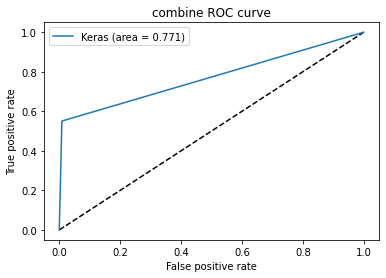

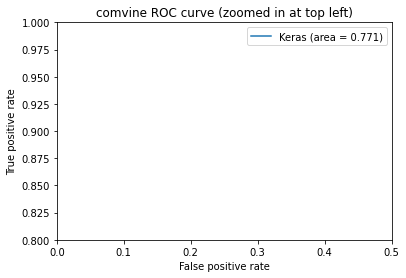

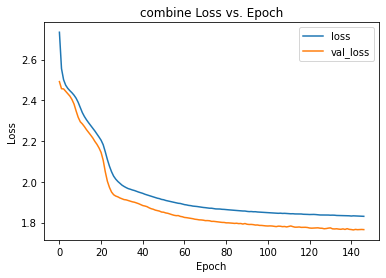

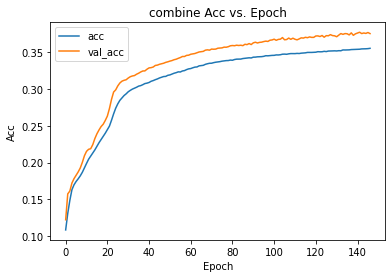

In [39]:
# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('combine ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/multi_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('comvine ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/multi_ROC_curve_zoom_1')
plt.show()

# plot loss vs epoch
plt.figure(3)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('combine Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/multi_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(history.history['sparse_categorical_accuracy'], label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('combine Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/multi_acc_epoch.png', format='png')
plt.show()

In [40]:
total_weight = np.sum(full_df.loc[:, b'genweight'].values)
test_total_weight = np.sum(X_val_weight)
scale_weight = total_weight / test_total_weight

In [41]:
# Make copy of dataframe
X_full = full_df.values
X_train_full, X_val_full, y_ph_1, y_ph_2 = train_test_split(X_full, Y, test_size = 0.2, random_state=random_seed)
X_val_full_df = pd.DataFrame(X_val_full, columns = list(full_df.columns))

result_df = pd.DataFrame()
for column in list(full_df.columns):
    result_df[column] = X_val_full_df.loc[:, column].values
result_df[b'genweight_scale'] = X_val_full_df.loc[:, b'genweight'] * scale_weight
result_df[b'actual_label'] = Y_val
result_df[b'predicted_label'] = predict_lab

In [45]:
result_df.head()

,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'nphoton',b'njet',b'run',b'lumi',b'event',b'label',b'label_num',b'genweight_scale',b'actual_label',b'predicted_label'
0,153.669,54.1855,182.956,169.572,205.5,31.4375,176.491,169.171,201.185,33.9857,...,2,6,1,20855,20020479,DiPhotonJetsBox,11,0.185526,11,11
1,114.586,64.6245,143.261,118.089,221.625,40.625,201.744,172.062,218.27,41.1407,...,2,7,1,4259,709848,VBFHToGG,4,-0.00623708,4,11
2,96.3447,60.5904,48.1087,151.136,51.4375,34.4688,49.6606,133.512,42.7223,41.1336,...,2,6,1,182539,536479802,GJet_BigPt,10,2.47125,10,11
3,88.8663,62.1672,87.607,130.932,103.438,36.9688,111.169,91.4639,93.8412,48.5576,...,2,10,1,43769,77055980,TTJets,6,-3.43518,6,6
4,118.965,90.284,197.546,128.107,114.375,68.25,153.506,103.837,114.71,71.4492,...,2,4,1,1336,133576,GluGluToHH,0,0.000108972,0,0


In [30]:
from ROOT import RDF
from ROOT import Internal

result_dict = {key.decode("utf-8"): result_df[key].values for key in list(result_df.columns)}
result_rdf = rt.RDF.MakeNumpyDataFrame(result_dict)
result_rdf.Snapshot('tree', f'DNN_Trees/full/multi_DNN_file.root')

RuntimeError: Object not convertible: Dictionary entry leading_photon_pt is not convertible with AsRVec.

In [44]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)):
    print(mc_labels[i])
    original_yield = np.sum(dfs_ggHH[i].loc[:, b'genweight'].values)
    samp_df = result_df[result_df[b'actual_label'] == i]
    remaining_df = samp_df[samp_df[b'predicted_label']==0]
    remaining_yield = np.sum(remaining_df.loc[:, b'genweight_scale'].values)
    print(f'Original yield: {original_yield}')
    print(f'Remaining yield: {remaining_yield}')
    print('\n')

original_bkd_yield = np.sum(full_df[full_df[b'label_num'] != 0].loc[:, b'genweight'].values)
original_sig_yield = np.sum(full_df[full_df[b'label_num'] == 0].loc[:, b'genweight'].values)
original_significance = original_sig_yield / np.sqrt(original_bkd_yield + original_sig_yield)
val_bkd = result_df[result_df[b'label_num'] != 0]
val_sig = result_df[result_df[b'label_num'] == 0]
remaining_bkd_yield = np.sum(val_bkd[val_bkd[b'predicted_label'] == 0].loc[:, b'genweight_scale'].values)
remaining_sig_yield = np.sum(val_sig[val_sig[b'predicted_label'] == 0].loc[:, b'genweight_scale'].values)
remaining_significance = remaining_sig_yield / np.sqrt(remaining_bkd_yield + remaining_sig_yield)
print(f'Original Background Yield: {original_bkd_yield}')
print(f'Original Signal Yield: {original_sig_yield}')
print(f'Original Significance: {original_significance}')
print(f'Remaining Background Yield: {remaining_bkd_yield}')
print(f'Remaining Signal Yield: {remaining_sig_yield}')
print(f'Remaining Significance: {remaining_significance}')

GluGluToHH
Original yield: 2.160290479660034
Remaining yield: 1.3515878709300975


VBFToHH
Original yield: 0.04713541641831398
Remaining yield: 0.010118191009367549


VHToGG
Original yield: 77.61676788330078
Remaining yield: 3.422945103915964


ttHToGG
Original yield: 8.006531715393066
Remaining yield: 0.6794078005443891


VBFHToGG
Original yield: 33.00462341308594
Remaining yield: 0.9973760966709836


GluGluHtoGG
Original yield: 446.37933349609375
Remaining yield: 8.916111495183257


TTJets
Original yield: 57538.75
Remaining yield: 1502.6343724556277


TTGJets
Original yield: 2033.285400390625
Remaining yield: 103.85578369277953


TTGG_0Jets
Original yield: 20.19515609741211
Remaining yield: 0.9687622029317312


GJet_SmallPt
Original yield: 1537.787841796875
Remaining yield: 0


GJet_BigPt
Original yield: 60913.47265625
Remaining yield: 319.40983093814947


DiPhotonJetsBox
Original yield: 6928.93115234375
Remaining yield: 31.512539078563858


DiPhotonJetsBox1B
Original yield: 2525.903

In [31]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)):
    original_mass_gg = dfs_ggHH[i].loc[:, b'diphoton_mass'].values
    original_mass_jj = dfs_ggHH[i].loc[:, b'dibjet_mass_corr'].values
    original_weight = dfs_ggHH[i].loc[:, b'genweight'].values
    samp_df = result_df[result_df[b'actual_label'] == i]
    remaining_df = samp_df[samp_df[b'predicted_label']==0]
    remaining_mass_gg = remaining_df.loc[:, b'diphoton_mass'].values
    remaining_mass_jj = remaining_df.loc[:, b'dibjet_mass_corr'].values
    remaining_weight = remaining_df.loc[:, b'genweight'].values
    
    
    bins = np.linspace(110, 140, 20)
    
    # M_gg plot
    plt.figure(figsize=(9,6))
    plt.hist(original_mass_gg, bins=bins, weights=original_weight, density=True, label = f'{mc_labels[i]} Original', color = 'blue')
    plt.hist(remaining_mass_gg, bins=bins, weights=remaining_weight, density=True, label = f'{mc_labels[i]} Remaining', color='orange', histtype='step')
    plt.xlabel('diphoton mass')
    plt.ylabel('normalized number of events')
    plt.title(f'{mc_labels[i]} Diphoton Mass Sculpting')
    plt.legend(loc='best')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/multi_gg_mass_sculpt_{mc_labels[i]}')
    plt.close()
    
    # M_jj plot
    plt.figure(figsize=(9,6))
    plt.hist(original_mass_jj, bins=bins, weights=original_weight, density=True, label = f'{mc_labels[i]} Original', color= 'blue')
    plt.hist(remaining_mass_jj, bins=bins, weights=remaining_weight, density=True, label = f'{mc_labels[i]} Remaining', color = 'orange', histtype='step')
    plt.xlabel('dibjet corrected mass')
    plt.ylabel('normalized number of events')
    plt.title(f'{mc_labels[i]} Dibjet Corrected Mass Sculpting')
    plt.legend(loc='best')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/multi_jj_mass_sculpt_{mc_labels[i]}')
    plt.close()

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


## Model Optimization

In [ ]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate'),
          Categorical(['relu', 'sigmoid', 'softmax']),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate')
         ]

def multi_DNN(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.00002):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=opt, metrics=[SparseCategoricalAccuracy()])
    return model

# @use_named_args(space)
# def objective(**X):
#     print("New configuration: {}".format(X))
#     model_tmp = multi_DNN(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'], X['activation_func'], X['lr'])
#     print (model_tmp)
#     model_tmp.fit(X_train, Y_train, epochs=200,batch_size=64, validation_split = 0.2, 
#            callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])
    
#     train_accuracy = model_tmp.evaluate(X_train, Y_train)[1]
#     print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
#     accuracy = model_tmp.evaluate(X_val, Y_val)[1]
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
#     return -accuracy